# Predicting flight delays using Python and GridDB

Due to the associated financial losses that the aviation industry is constantly experiencing, flight delays have become a very important topic for air transportation all over the world.

The causes of these delays are many and diverse, ranging from air traffic congestion to weather conditions, mechanical issues, challenges with passenger boarding, and simply the airlines' inability to meet demand given their capacity.

Based on historical data of flight delays, we will first analyse the reasons for delays and then we will predict flight delay time prediction. 

The outline of the tutorial is as follows:

 1. Dataset overview
 2. Importing required libraries
 3. Loading the dataset
 4. Data Preporcessing and data visualization
 5. Predictions
 6. Conclusion

# Prerequisites and Environment setup

This tutorial is carried out in Anaconda Navigator (Python version – 3.8.5) on Windows Operating System. The following packages need to be installed before you continue with the tutorial –

1. Pandas

2. NumPy

3. sklearn

4. Matplotlib

5. Seaborn

6. statsmodels

You can install these packages in Conda’s virtual environment using `conda install package-name`. In case you are using Python directly via terminal/command prompt, `pip install package-name` will do the work.

### GridDB installation

While loading the dataset, this tutorial will cover two methods – Using GridDB as well as Using Pandas. To access GridDB using Python, the following packages also need to be installed beforehand:

1. [GridDB C-client](https://github.com/griddb/c_client)
2. SWIG (Simplified Wrapper and Interface Generator)
3. [GridDB Python Client](https://github.com/griddb/python_client)

# 1. Dataset Overview

The Bureau of Transportation Statistics of the United States Department of Transportation (DOT) monitors the on-time performance of domestic flights operated by large air carriers. The DOT's monthly Air Travel Consumer Report and this dataset of 2015 flight delays and cancellations contain summary information on the number of on-time, delayed, cancelled, and diverted flights.

https://www.kaggle.com/code/manasichhibber/flight-delay-predictions/data

# 2. Importing Required Libraries


In [21]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import requests
import http
http.client.HTTPConnection.debuglevel = 1
from requests.auth import HTTPBasicAuth

import numpy as np   
import statsmodels.formula.api as sm
import datetime
import time
from time import strftime, gmtime
import statsmodels.formula.api as smf
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from sklearn import ensemble,gaussian_process,linear_model,naive_bayes,neighbors,svm,tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score,precision_score,recall_score,auc

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from random import sample


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

# 3. Loading the Dataset

Toshiba GridDB™ is a highly scalable NoSQL database best suited for IoT and Big Data. The foundation of GridDB’s principles is based upon offering a versatile data store that is optimized for IoT, provides high scalability, tuned for high performance, and ensures high reliability.

To store large amounts of data, a CSV file can be cumbersome. GridDB serves as a perfect alternative as it in open-source and a highly scalable database. GridDB is a scalable, in-memory, No SQL database which makes it easier for you to store large amounts of data. If you are new to GridDB, a tutorial on  [reading and writing to GridDB](https://griddb.net/en/blog/using-pandas-dataframes-with-griddb/)  can be useful.

## Setting up a Container in GridDB to store the data


The aim of this blog post is to showcase the noteworthy features of GridDB, including:

- Retrieving data using SQL with sub-queries, case statements, group by clauses, having clauses and nested sub-queries.
- Exploring the two container types offered by GridDB: Collections and Time Series. For more information on GridDB data modeling, read this article. (https://griddb.net/en/blog/data-modeling-with-griddb)

Get started by subscribing to GridDB Cloud. (https://griddb.net/en/blog/an-introduction-to-griddb-cloud/)

The file ‘container_columns’ has all the headers and their datatypes. One last step is to change the Python datatypes to GridDB datatypes. Click here (https://docs.griddb.net/tqlreference/type/#primitive) to learn more about the datatypes supported by GridDB and their respective notations.

In [2]:
flights = pd.read_csv('flights.csv')

# Extracting column headers for the GridDB WebApi Container structure
col_vals = (list(flights.columns.values))
col_dtypes = (list(flights.dtypes))
data_tuples = list(zip(col_vals,col_dtypes)) # Binding lists to a tuple

# Converting list of tuples to pandas dataframe
container_columns1 = pd.DataFrame(data_tuples, columns=['col_vals','col_datatypes'])
container_columns1.to_csv('container_columns1.csv',index=False)
container_columns1 = container_columns1.dropna(how='any',axis=0)
container_columns1 #column names for the container

,col_vals,col_datatypes
0,YEAR,int64
1,MONTH,int64
2,DAY,int64
3,DAY_OF_WEEK,int64
4,AIRLINE,object
5,FLIGHT_NUMBER,int64
6,TAIL_NUMBER,object
7,ORIGIN_AIRPORT,object
8,DESTINATION_AIRPORT,object
9,SCHEDULED_DEPARTURE,int64


In [3]:
airlines = pd.read_csv('airlines.csv')

col_vals = (list(airlines.columns.values))
col_dtypes = (list(airlines.dtypes))
data_tuples = list(zip(col_vals,col_dtypes)) 

container_columns2 = pd.DataFrame(data_tuples, columns=['col_vals','col_datatypes'])
container_columns2.to_csv('container_columns2.csv',index=False)
container_columns2 = container_columns2.dropna(how='any',axis=0)

container_columns2 

,col_vals,col_datatypes
0,IATA_CODE,object
1,AIRLINE,object


In [4]:
airports = pd.read_csv('airports.csv')

col_vals = (list(airports.columns.values))
col_dtypes = (list(airports.dtypes))
data_tuples = list(zip(col_vals,col_dtypes))

container_columns3 = pd.DataFrame(data_tuples, columns=['col_vals','col_datatypes'])
container_columns3.to_csv('container_columns3.csv',index=False)
container_columns3 = container_columns3.dropna(how='any',axis=0)

container_columns3

,col_vals,col_datatypes
0,IATA_CODE,object
1,AIRPORT,object
2,CITY,object
3,STATE,object
4,COUNTRY,object
5,LATITUDE,float64
6,LONGITUDE,float64


In [5]:
typ = {'int64': 'INTEGER', 'float64': 'FLOAT', 'object': 'STRING'}

In [6]:
container_columns1['col_datatypes'] = container_columns1['col_datatypes'].map(typ)
container_columns2['col_datatypes'] = container_columns2['col_datatypes'].map(typ)
container_columns3['col_datatypes'] = container_columns3['col_datatypes'].map(typ)

Setting up a Container in GridDB to store the data. To learn more about creating a container in GridDB, refer to this resource of GridDB. (https://docs.griddb.net/architecture/data-model/#container)


In [ ]:
#Construct an object to hold the request headers (ensure that you replace the XXX placeholder with the correct value that matches the credentials for your GridDB instance)
header_obj = {"Authorization":"[Auth-token]","Content-Type":"application/json; charset=UTF-8","User-Agent":"PostmanRuntime/7.29.0"}

#Construct the base URL based on your GridDB cluster you'd like to connect to (ensure that you replace the placeholders in the URL below with the correct values that correspond to your GridDB instance)
base_url = 'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]'

In [ ]:
c1 = []
c2 = []
c3 = []

class create_dict(dict):

    def __init__(self):
        self = dict()

    def add(self, key, value):
        self[key] = value


def format_to_dic(a,b):
    dct = create_dict()
    dct.add('name', a)
    dct.add('type', b)

    return dct


for i in range(len(container_columns1)):
    c1.append(format_to_dic(container_columns1.iloc[i,0], container_columns1.iloc[i,1]))
    
for i in range(len(container_columns2)):
    c2.append(format_to_dic(container_columns2.iloc[i,0], container_columns2.iloc[i,1]))
    
for i in range(len(container_columns3)):
    c3.append(format_to_dic(container_columns3.iloc[i,0], container_columns3.iloc[i,1]))

In [ ]:
#Construct an object to hold the request body (i.e., the container that needs to be created)
data_obj1 = {
    "container_name": "flights",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": c1
}

data_obj2 = {
    "container_name": "airlines",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": c2 
}

data_obj3 = {
    "container_name": "airports",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": c3
}

#Set up the GridDB WebAPI URL
url = base_url + '/containers'

#Invoke the GridDB WebAPI with the headers and the request body
x1 = requests.post(url, json = data_obj1, headers = header_obj,auth=HTTPBasicAuth([username], [password]))
x2 = requests.post(url, json = data_obj2, headers = header_obj,auth=HTTPBasicAuth([username], [password]))
x3 = requests.post(url, json = data_obj3, headers = header_obj,auth=HTTPBasicAuth([username], [password]))

Loading Data into the GridDB container (Row Registration)
To learn more on the format required to add rows to the container, refer to this article. (http://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_3/GridDB_Web_API_Reference.html#%E3%83%AD%E3%82%A6%E7%99%BB%E9%8C%B2)

In [ ]:
flights = flights.to_json(orient='values')
request_body1 = flights

airlines = airlines.to_json(orient='values')
request_body2 = airlines

airports = airports.to_json(orient='values')
request_body3 = airports

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url1 = base_url + '/containers/flights/rows'
url2 = base_url + '/containers/airlines/rows'
url3 = base_url + '/containers/airports/rows'


#Invoke the GridDB WebAPI using the request constructed
x1 = requests.put(url1, data=request_body1, headers=header_obj,auth=HTTPBasicAuth([username], [password]))
x2 = requests.put(url2, data=request_body2, headers=header_obj,auth=HTTPBasicAuth([username], [password]))
x3 = requests.put(url3, data=request_body3, headers=header_obj,auth=HTTPBasicAuth([username], [password]))

In [ ]:
#Construct the SQL to be used
sql1 = ("SELECT * FROM flights")
sql2 = ("SELECT * FROM airlines")
sql3 = ("SELECT * FROM airports")

url = base_url + '/sql'
request_body1 = '[{"type":"sql-select", "stmt":"'+sql1+'"}]'
request_body2 = '[{"type":"sql-select", "stmt":"'+sql2+'"}]'
request_body3 = '[{"type":"sql-select", "stmt":"'+sql3+'"}]'

Invoke the GridDB SQL API to retrieve the results and process it.

In [ ]:
data_req1 = requests.post(url, data=request_body1, headers=header_obj,auth=HTTPBasicAuth([username], [password]))
data_req2 = requests.post(url, data=request_body2, headers=header_obj,auth=HTTPBasicAuth([username], [password]))
data_req3 = requests.post(url, data=request_body3, headers=header_obj,auth=HTTPBasicAuth([username], [password]))


myJson1 = data_req1.json()
flights = pd.DataFrame(myJson1[0]["results"], columns=[myJson1[0]["columns"][0]["name"], myJson1[0]["columns"][1]["name"]])

myJson2 = data_req2.json()
airlines = pd.DataFrame(myJson2[0]["results"], columns=[myJson2[0]["columns"][0]["name"], myJson2[0]["columns"][1]["name"]])

myJson3 = data_req1.json()
airports = pd.DataFrame(myJson3[0]["results"], columns=[myJson3[0]["columns"][0]["name"], myJson3[0]["columns"][1]["name"]])

When it comes to IoT and Big Data use cases, GridDB clearly stands out among other databases in the Relational and NoSQL space.
Overall, GridDB offers multiple reliability features for mission-critical applications that require high availability and data retention.

# 4. Preprocessing and Data Visualization

Various Plots are created so as to get a great idea of whats happening in the Dataset and what is the most important variable affecting the dalays of the airlines.

In [7]:
df_flights = flights

In [8]:
# converting to datetime.
def conv_time(time_val):
    if pd.isnull(time_val):
        return np.nan
    else:
        if time_val == 2400: time_val = 0
        time_val = "{0:04d}".format(int(time_val))
        time_formatted = datetime.time(int(time_val[0:2]), int(time_val[2:4]))
    return time_formatted

In [9]:
df_flights['ARRIVAL_TIME'] = df_flights['ARRIVAL_TIME'].apply(conv_time)
df_flights['DEPARTURE_TIME'] = df_flights['DEPARTURE_TIME'].apply(conv_time)
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(conv_time)
df_flights['WHEELS_OFF'] = df_flights['WHEELS_OFF'].apply(conv_time)
df_flights['WHEELS_ON'] = df_flights['WHEELS_ON'].apply(conv_time)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(conv_time)

After we've converted the necessary time values to a DateTime datatype, we need to validate our data. Null values and missing data are common data states that must be handled.

In [10]:
df_flights['AIRLINE_DELAY'] = df_flights['AIRLINE_DELAY'].fillna(0)
df_flights['AIR_SYSTEM_DELAY'] = df_flights['AIR_SYSTEM_DELAY'].fillna(0)
df_flights['SECURITY_DELAY'] = df_flights['SECURITY_DELAY'].fillna(0)
df_flights['LATE_AIRCRAFT_DELAY'] = df_flights['LATE_AIRCRAFT_DELAY'].fillna(0)
df_flights['WEATHER_DELAY'] = df_flights['WEATHER_DELAY'].fillna(0)

In [11]:
df_flights['CANCELLATION_REASON'].value_counts()

B    48851
A    25262
C    15749
D       22
Name: CANCELLATION_REASON, dtype: int64

As can be seen, the primary reason for cancellation is B the weather. Weather is well known to be a major cause of delays and cancellations. In the case of this attribute, we consider the weather to be a cancellation reason rather than a delay reason.

In [12]:
# converting categoric value to numeric
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'A', 'CANCELLATION_REASON'] = 1
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'B', 'CANCELLATION_REASON'] = 2
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'C', 'CANCELLATION_REASON'] = 3
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'D', 'CANCELLATION_REASON'] = 4

# converting NaN to zero
df_flights['CANCELLATION_REASON'] = df_flights['CANCELLATION_REASON'].fillna(0)

In [13]:
df_flights = df_flights.dropna(axis=0)
df_flights.isnull().sum()


YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64

In [14]:
df_airlines = airlines

In [15]:
df_flights = df_flights.merge(df_airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')

In [16]:
# dropping old column and rename new one
df_flights = df_flights.drop(['AIRLINE_x','IATA_CODE'], axis=1)
df_flights = df_flights.rename(columns={"AIRLINE_y":"AIRLINE"})

Distribution Analysis following Cleansing, Conversion, and preprocessing the features of data. Now we need to identify the features that are most likely to influence flight delays for our prediction.

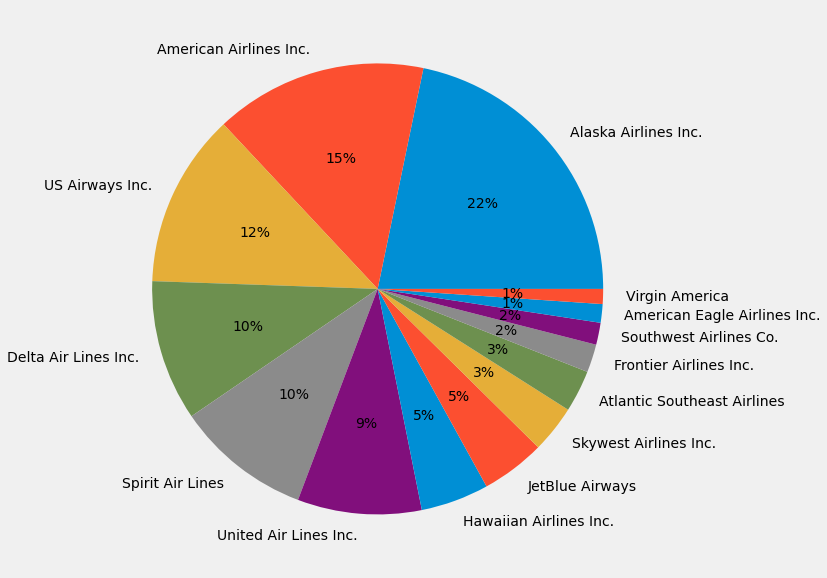

In [17]:
fig_dim = (9,10)
f, ax = plt.subplots(figsize=fig_dim)
quality=df_flights["AIRLINE"].unique()
size=df_flights["AIRLINE"].value_counts()

plt.pie(size,labels=quality,autopct='%1.0f%%')
plt.show()

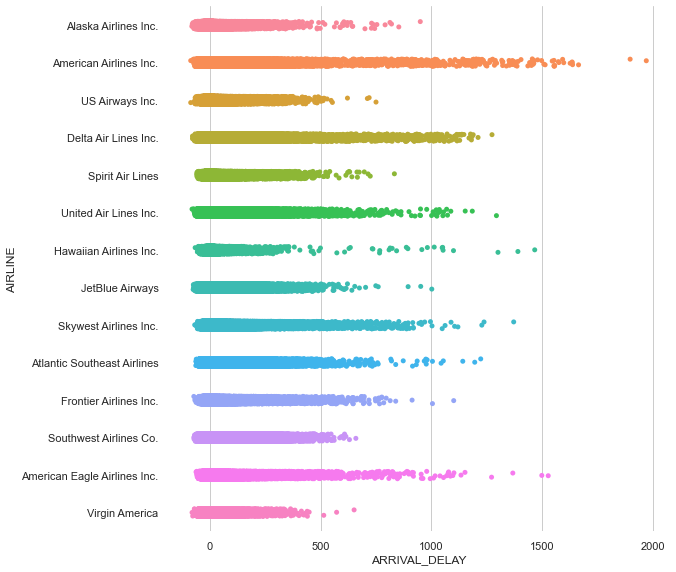

In [18]:
sns.set(style="whitegrid")

fig_dim = (8,9)
f, ax = plt.subplots(figsize=fig_dim)
sns.despine(bottom=True, left=True)
sns.stripplot(x="ARRIVAL_DELAY", y="AIRLINE",
              data=df_flights, dodge=True, jitter=True
            )
plt.show()

The distribution above compares the airlines to their ARRIVAL DELAYs. It clearly demonstrates that American Airlines has a wide range of delays.

# 5. Predictions

In [19]:
# Marking the delayed flights

df_flights['DELAYED'] = df_flights.loc[:,'ARRIVAL_DELAY'].values > 0

y = df_flights.DELAYED

# Choosing the indeoendent variable
feature_list_s = [
    'LATE_AIRCRAFT_DELAY'
    ,'AIRLINE_DELAY'
    ,'AIR_SYSTEM_DELAY'
    ,'WEATHER_DELAY'
    ,'ELAPSED_TIME']

X_small = df_flights[feature_list_s]

In [22]:
# Baseline-Model RandomForestClassifier 
clf = RandomForestClassifier(n_estimators = 10, random_state=32) 
clf.fit(X_small, y)

RandomForestClassifier(n_estimators=10, random_state=32)

In [23]:
importances=clf.feature_importances_
importances=pd.DataFrame([X_small.columns,importances]).transpose()
importances.columns=[['Variables','Importance']]
importances

,Variables,Importance
0,LATE_AIRCRAFT_DELAY,0.261898
1,AIRLINE_DELAY,0.331247
2,AIR_SYSTEM_DELAY,0.374424
3,WEATHER_DELAY,0.022457
4,ELAPSED_TIME,0.009974


In [24]:
# choosing the predictors
feature_list = [
    'YEAR'
    ,'MONTH'
    ,'DAY'
    ,'LATE_AIRCRAFT_DELAY'
    ,'AIRLINE_DELAY'
    ,'AIR_SYSTEM_DELAY'
    ,'WEATHER_DELAY'
    ,'ELAPSED_TIME'
    ,'DEPARTURE_DELAY'
    ,'SCHEDULED_TIME'
    ,'AIR_TIME'
    ,'DISTANCE'
    ,'TAXI_IN'
    ,'TAXI_OUT'
    ,'DAY_OF_WEEK'
    ,'SECURITY_DELAY'
]
# Any number can be used in place of '0'. 
import random
random.seed(0)
    
df_flights_1=df_flights.sample(n=50000)
X = df_flights_1[feature_list]

In [25]:
y = df_flights_1.DELAYED
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
from sklearn.preprocessing import scale
X_train=scale(X_train)
X_test=scale(X_test)

In [26]:
MLA = [ ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    neighbors.KNeighborsRegressor()]

In [27]:
MLA_col = []
MLA_compare = pd.DataFrame(columns = MLA_col)
results=[]

row_index = 0
for alg in MLA:
    
    cv_results = cross_val_score(alg, X_train, y_train, cv=10)
    results.append(cv_results)
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    
    
    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA AUC
6,RandomForestRegressor,0.9685,0.7627,0.980933
1,BaggingRegressor,0.9541,0.7421,0.972318
4,ExtraTreesRegressor,1.0000,0.6902,0.965403
5,GradientBoostingRegressor,0.6738,0.6448,0.957092
2,DecisionTreeRegressor,1.0000,0.5221,0.879064
0,AdaBoostRegressor,0.5229,0.4999,0.854699
7,KNeighborsRegressor,0.6420,0.4382,0.858056
3,ExtraTreeRegressor,1.0000,0.3040,0.826076


The below plot shows the test train accuracy with respect to each models.

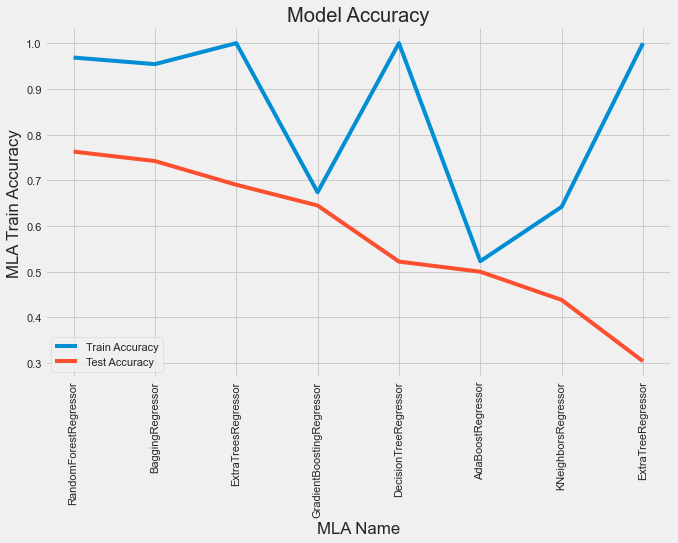

In [28]:
plt.subplots(figsize=(10,6))
sns.lineplot(x="MLA Name", y="MLA Train Accuracy",data=MLA_compare,palette='hot',label='Train Accuracy')
sns.lineplot(x="MLA Name", y="MLA Test Accuracy",data=MLA_compare,palette='hot',label='Test Accuracy')
plt.xticks(rotation=90)
plt.title('Model Accuracy')
plt.legend()
plt.show()

So this is basiccally the Test accuracy result of each models, where we can see Random Forest is giving us the best results.

# 6. Conclusion

In this tutorial we analysed and predicted flight delays using Python and GridDB. We examined two ways to import our data, using (1) GridDB and (2) Pandas. For large datasets, GridDB provides an excellent alternative to import data in your notebook as it is open-source and highly scalable. [Download GridDB](https://griddb.net/en/downloads/) today!